In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.functional import jacobian

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# input convex neural network
class ICNN(nn.Module):
    def __init__(self, n_dim, hidden_dims):
        super(ICNN, self).__init__()
        self.n_dim = n_dim
        self.hidden_dims = hidden_dims

        self.Wx_layers = nn.ModuleList()
        self.Wz_layers = nn.ModuleList()
        self.b = nn.ParameterList()

        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        prev_dim = 0
        for idx, hidden_dim in enumerate(hidden_dims):
            wx = nn.Linear(n_dim, hidden_dim)
            wz = nn.Linear(prev_dim, hidden_dim)

            if idx==0:
                with torch.no_grad():
                    wz.weight.zero_()

            self.Wx_layers.append(wx)
            self.Wz_layers.append(wz)
            self.b.append(nn.Parameter(torch.zeros(hidden_dim)))

            prev_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_dims[-1], 1, bias=False)

    def forward(self, x):
        z = None
        for i in range(len(self.hidden_dims)):
            wx_x = self.Wx_layers[i](x)
            if i==0:
                linear_sum = wx_x + self.b[i]
            else:
                wz_z = self.Wz_layers[i](z)
                linear_sum = wx_x + wz_z + self.b[i]
            z = F.softplus(linear_sum)

        output = self.output_layer(z)
        return output

    def enforce_constraints(self):
        """
        Enforces the non-negativity constraint on W^(z) weights.
        This should be called after the optimizer.step() during training.
        """
        with torch.no_grad(): # No gradient tracking needed for this operation
            for i in range(1, len(self.Wz_layers)): # Start from layer 1 (W0^(z) is fixed at 0)
                # Clamp weights to be non-negative
                self.Wz_layers[i].weight.copy_(torch.abs(self.Wz_layers[i].weight))
                # Alternative: Take absolute value
                # self.Wz_layers[i].weight.copy_(torch.abs(self.Wz_layers[i].weight))



#sampling from target distribution
def sample_exact(n_samples):
    theta = np.random.randn(n_samples)
    r     = 1.0 + 0.1 * np.random.randn(n_samples)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.stack([x, y], axis=1)

#log_rho of exact distribution
def log_rho_exact(xy):
    x = xy[:,0]
    y = xy[:,1]
    r     = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)


    log_p_theta = -0.5*theta**2 - 0.5*np.log(2*np.pi)

    log_p_r = (
        -0.5*((r - 1.0)/0.1)**2
        - 0.5*np.log(2*np.pi*0.1**2)
    )

    # log Jacobian term
    log_jac = -np.log(r)

    return log_p_theta + log_p_r + log_jac


def grad_F(model, x):
    x = x.clone().detach().requires_grad_(True)
    Fval = model(x).sum()
    grad = torch.autograd.grad(Fval, x, create_graph=True)[0]
    return grad


def flow_and_logdet(model, z0, betas):
    z = z0
    total_logdet = torch.zeros(z0.size(0), device=z0.device)
    for beta in  betas:
        z = z.requires_grad_(True)
        Fval = model(z).sum()
        grad = torch.autograd.grad(Fval, z, create_graph=True)[0]
        

        # Compute Hessian row by row
        B, d = z.shape
        H_rows = []
        for i in range(d):
            grad_i = grad[:, i].sum()
            Hi = torch.autograd.grad(grad_i, z, retain_graph=True, create_graph=True)[0]
            H_rows.append(Hi.unsqueeze(2))
        H = torch.cat(H_rows, dim=2)  # [B,d,d]

        I = torch.eye(d, device=z.device).unsqueeze(0).expand(B, d, d)
        J = I + beta * H

        sign, logabs = torch.slogdet(J)
        total_logdet += logabs

        z = z + beta * grad
        

    return z, total_logdet

def inverse_flow(model, z, betas):
    for beta in reversed(betas):
        z = z - beta * grad_F(model, z)
    return z

class MultiStepICNN(nn.Module):
    def __init__(self, n_dim, hidden_dims, n_steps):
        super(MultiStepICNN, self).__init__()
        self.n_steps = n_steps
        self.models = nn.ModuleList([
            ICNN(n_dim, hidden_dims) for _ in range(n_steps)
        ])
    
    def forward(self, x, step):
        """Forward pass for a specific step"""
        return self.models[step](x)
    
    def enforce_constraints(self):
        """Enforce constraints for all models"""
        for model in self.models:
            model.enforce_constraints()


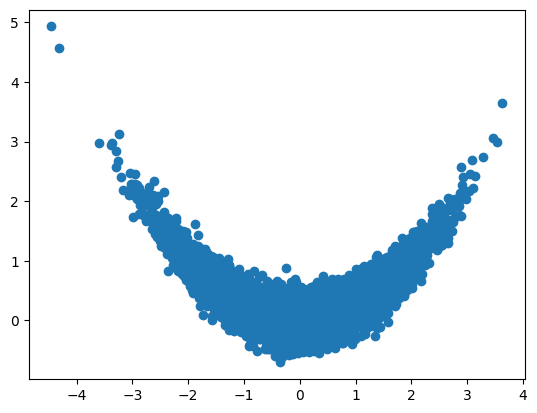

In [3]:
def sample_banana(n_samples=5000, sigma=1.0, noise=0.2):
    u = np.random.normal(0, sigma, size=n_samples)
    x1 = u
    x2 = (u**2)/4 + np.random.normal(0, noise, size=n_samples)
    return np.stack([x1, x2], axis=1)

# Sample data
X = sample_banana(10000)
plt.scatter(X[:,0], X[:,1])

In [5]:
from torch.utils.data import DataLoader, TensorDataset

X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

DIM = 2
HIDDEN_DIMS = [16, 32, 16]

model = ICNN(DIM, HIDDEN_DIMS).to(device)


EPOCHS = 200
K = 10
betas = nn.Parameter(torch.ones(K))

base = torch.distributions.MultivariateNormal(torch.zeros(DIM, device=device), torch.eye(DIM, device=device))

optimizer = torch.optim.Adam(list(model.parameters()) + [betas], lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5)
# Training loop
for epoch in range(1, EPOCHS + 1):
    total_loss = 0.0
    for (x_batch,) in dataloader:
        x_batch = x_batch.to(device)


        zK, logdet = flow_and_logdet(model, x_batch, betas)
        logp0 = base.log_prob(zK)
        logpx = logp0 + logdet

        loss = -logpx.mean()  # NLL = reverse KL

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.enforce_constraints()

        total_loss += loss.item() * x_batch.size(0)
    
    scheduler.step(total_loss / len(X_tensor))
    
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{EPOCHS}, NLL = {total_loss/len(X):.4f}")

/home/mohamed/miniconda3/lib/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch 5/200, NLL = 2.0527
Epoch 10/200, NLL = 1.9283
Epoch 15/200, NLL = 1.8262
Epoch 20/200, NLL = 1.7388
Epoch 25/200, NLL = 1.6448
Epoch 30/200, NLL = 1.5439
Epoch 35/200, NLL = 1.4587
Epoch 40/200, NLL = 1.3964
Epoch 45/200, NLL = 1.3575
Epoch 50/200, NLL = 1.3310
Epoch 55/200, NLL = 1.3084
Epoch 60/200, NLL = 1.2915
Epoch 65/200, NLL = 1.2774
Epoch 70/200, NLL = 1.2714
Epoch 75/200, NLL = 1.2613
Epoch 80/200, NLL = 1.2597
Epoch 85/200, NLL = 1.2596
Epoch 90/200, NLL = 1.2559
Epoch 95/200, NLL = 1.2546
Epoch 100/200, NLL = 1.2548
Epoch 105/200, NLL = 1.2580


KeyboardInterrupt: 

/home/mohamed/miniconda3/lib/python3.12/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


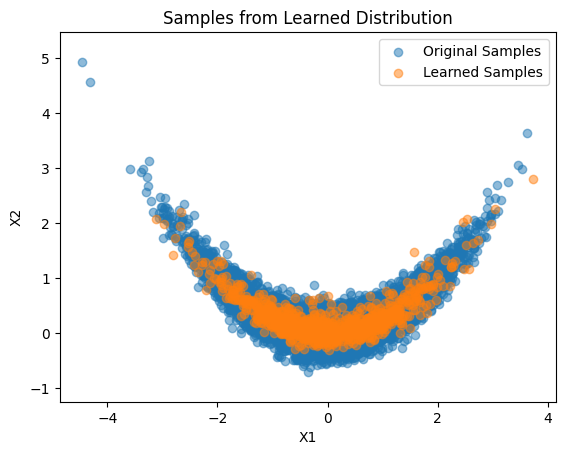

In [6]:
flow_samples = inverse_flow(model, base.sample_n(1000), betas)
flow_samples = flow_samples.detach().cpu().numpy()
plt.scatter(X[:,0], X[:,1], alpha=0.5, label='Original Samples')
plt.scatter(flow_samples[:,0], flow_samples[:,1], label='Learned Samples', alpha=0.5)
plt.title('Samples from Learned Distribution')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.axis('equal')
plt.show()

Text(0.5, 1.0, 'Transformed Base Distribution Samples')

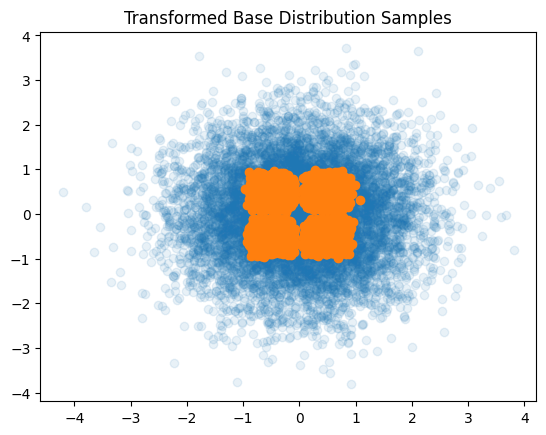

In [20]:
base = torch.distributions.MultivariateNormal(torch.zeros(2, device=device), torch.eye(2, device=device))
def T(xy):
    x = xy[:,0]
    y = xy[:,1]
    return np.stack([np.cbrt(1/4 * x), np.cbrt(1/4 * y)], axis=1)

X = T(base.sample_n(10000).cpu().numpy())

base_samples = base.sample_n(10000).cpu().numpy()
plt.scatter(base_samples[:,0], base_samples[:,1], alpha=0.1, label='Base Samples')
plt.scatter(X[:,0], X[:,1], alpha=1, label='Transformed Samples')
plt.title('Transformed Base Distribution Samples')

/home/mohamed/miniconda3/lib/python3.12/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


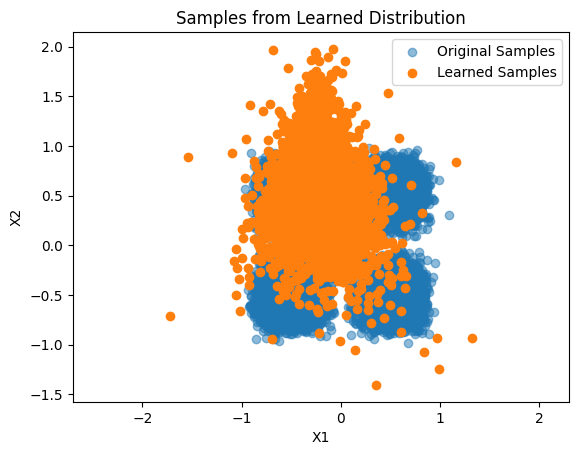

In [56]:
base_samples = base.sample_n(10000)
flow_samples = inverse_flow_multistep(model, base_samples, betas)
flow_samples = flow_samples.detach().cpu().numpy()

plt.scatter(X[:,0], X[:,1], alpha=0.5, label='Original Samples')
plt.scatter(flow_samples[:,0], flow_samples[:,1], label='Learned Samples', alpha=1)
plt.title('Samples from Learned Distribution')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(loc='upper right')
plt.axis('equal')
plt.show()

In [ ]:
plt.scatter(base_samples[:,0], base_samples[:,1], alpha=0.1, label='Base Samples')


In [ ]:
import torch
import math
from torch.utils.data import DataLoader, TensorDataset

def logp_banana(x, sigma=0.2):  
    """
    Log probability of banana distribution
    x1 ~ N(0, 1)
    x2 ~ N(x1^2/4, sigma^2)
    """
    x1 = x[:,0]
    x2 = x[:,1]

    log1 = -0.5 * (x1**2 + math.log(2*math.pi))
    

    resid = x2 - 0.25 * x1**2
    log2 = -0.5 * ((resid**2)/(sigma**2) + math.log(2*math.pi*(sigma**2)))
    
    return log1 + log2  

def estimate_kl_debug(model, betas, data_loader, sigma=0.2, device='cuda'):
    """
    Estimate KL divergence with debugging information
    KL(p||q) = E_p[log p(x) - log q(x)]
    """
    total = 0.0
    count = 0
    logp_total = 0.0
    logq_total = 0.0
    

    for (x_batch,) in data_loader:
        x = x_batch.to(device)
        

        zK, logdet = flow_and_logdet(model, x, betas)
        logq = base.log_prob(zK) + logdet   # shape (B,)
        
        logp = logp_banana(x, sigma=sigma)
        if isinstance(logp, torch.Tensor):
            logp = logp.to(device)
        else:
            logp = torch.tensor(logp, device=device)
        

        kl_batch = logp - logq
        

        total += kl_batch.detach().sum().item()
        logp_total += logp.detach().sum().item()
        logq_total += logq.detach().sum().item()
        count += x.size(0)
    
    print(f"Average log p (true): {logp_total/count:.4f}")
    print(f"Average log q (flow): {logq_total/count:.4f}")
    print(f"Average difference: {(logp_total - logq_total)/count:.4f}")
    
    return total/count

X_consistent = sample_banana(n_samples=10000, sigma=1.0, noise=0.2)  # noise=0.2
X_tensor_consistent = torch.tensor(X_consistent, dtype=torch.float32).to(device)
data_loader_consistent = DataLoader(TensorDataset(X_tensor_consistent), batch_size=1000, shuffle=False)


print("\n=== KL Divergence Estimation ===")
kl = estimate_kl_debug(model, betas, dataloader, sigma=0.2, device=device)
print(f"Estimated KL(p||q) = {kl:.6f}")



=== Generating fresh data with correct parameters ===

=== KL Divergence Estimation ===
Average log p (true): -1.1985
Average log q (flow): -1.5437
Average difference: 0.3453
Estimated KL(p||q) = 0.345251


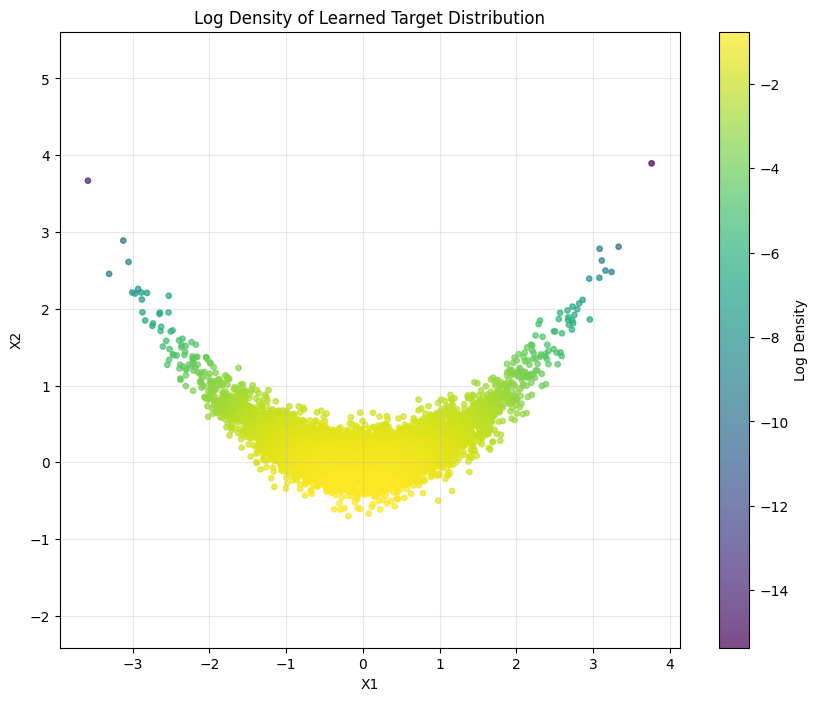

Creating density heatmap on regular grid...


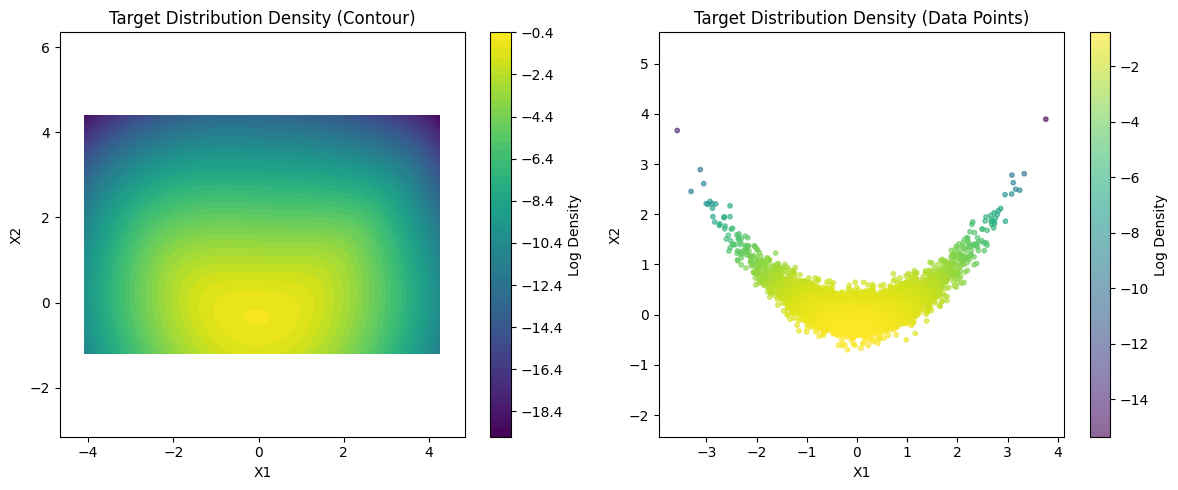

In [ ]:
# Visualize the learned flow distribution (target distribution)
X_vis = torch.tensor(X, dtype=torch.float32, device=device)

# Compute the log density of the target distribution

_, logdet = flow_and_logdet(model, X_vis, betas)
    # base.log_prob returns shape (B,) not (B,2), so no sum needed
log_density = base.log_prob(X_vis) + logdet

log_density_np = log_density.detach().cpu().numpy()

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X[:,0], X[:,1], c=log_density_np, cmap='viridis', s=15, alpha=0.7)
plt.colorbar(scatter, label='Log Density')
plt.title('Log Density of Learned Target Distribution')
plt.xlabel('X1')
plt.ylabel('X2')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

print("Creating density heatmap on regular grid...")
x_range = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 100)
y_range = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
grid_points = torch.tensor(np.stack([X_grid.ravel(), Y_grid.ravel()], axis=1), 
                          dtype=torch.float32, device=device)


_, logdet_grid = flow_and_logdet(model, grid_points, betas)
log_density_grid = base.log_prob(grid_points) + logdet_grid

log_density_grid = log_density_grid.detach().cpu().numpy().reshape(X_grid.shape)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(X_grid, Y_grid, log_density_grid, levels=50, cmap='viridis')
plt.colorbar(label='Log Density')
plt.title('Target Distribution Density (Contour)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(X[:,0], X[:,1], c=log_density_np, cmap='viridis', s=10, alpha=0.6)
plt.colorbar(label='Log Density')
plt.title('Target Distribution Density (Data Points)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.axis('equal')

plt.tight_layout()
plt.show()

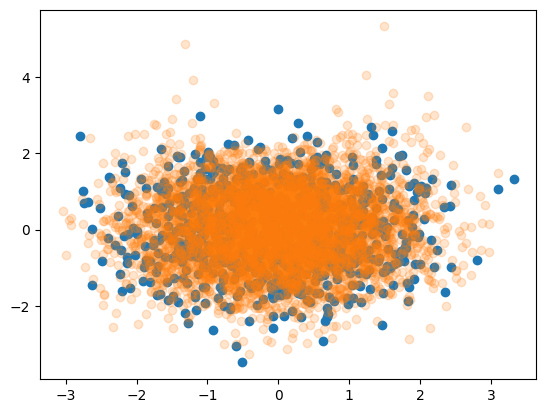

In [20]:
base_samples = base.sample_n(1000).cpu().numpy()
plt.scatter(base_samples[:,0], base_samples[:,1], alpha=1, label='Base Distribution Samples')
flow_samples, _ = flow_and_logdet(model, X_tensor.to(device), betas)
flow_samples = flow_samples.detach().cpu().numpy()
plt.scatter(flow_samples[:,0], flow_samples[:,1], label='Learned Samples', alpha=0.2)

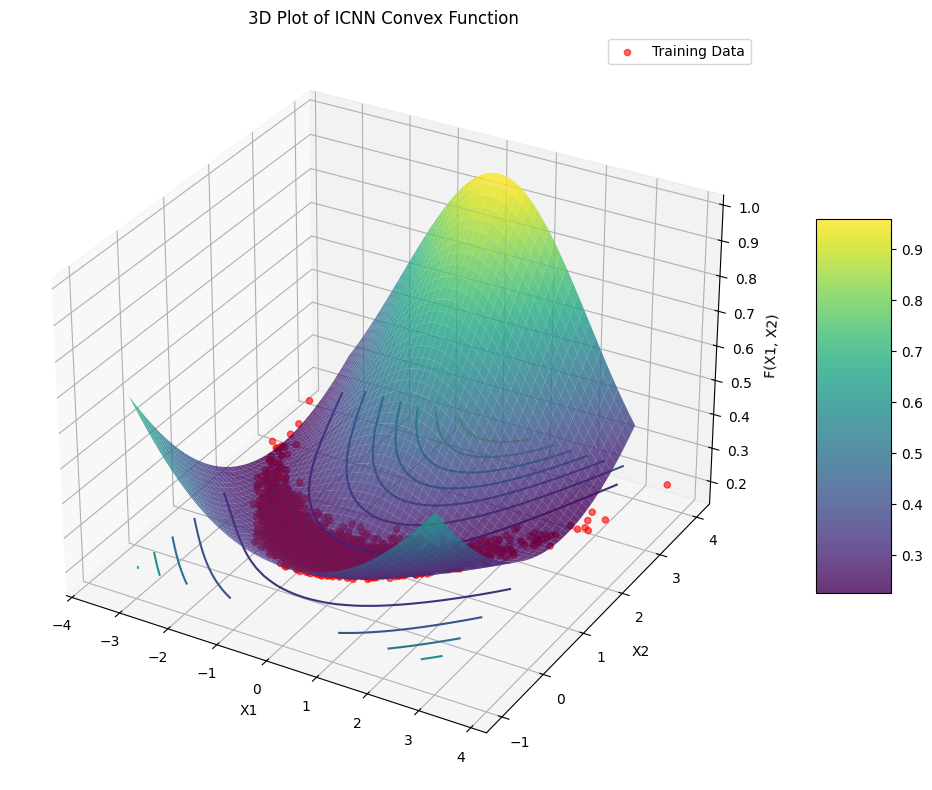

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch

# Create a grid of points for plotting
x_range = np.linspace(-3, 3, 50)
y_range = np.linspace(-1, 4, 50)
X_grid, Y_grid = np.meshgrid(x_range, y_range)

# Flatten the grid for model input
grid_points = np.stack([X_grid.ravel(), Y_grid.ravel()], axis=1)
grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

# Evaluate the ICNN function on the grid
with torch.no_grad():
    Z_values = model(grid_tensor).cpu().numpy()

# Reshape back to grid shape
Z_grid = Z_values.reshape(X_grid.shape)

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', alpha=0.8)

# Add contour lines at the bottom
contours = ax.contour(X_grid, Y_grid, Z_grid, zdir='z', offset=Z_grid.min(), cmap='viridis')

# Optionally overlay the data points
X_np = X_tensor.cpu().numpy()
F_vals = model(X_tensor.to(device)).detach().cpu().numpy()
ax.scatter(X_np[:, 0], X_np[:, 1], F_vals.flatten(), 
           c='red', s=20, alpha=0.6, label='Training Data')

# Labels and title
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('F(X1, X2)')
ax.set_title('3D Plot of ICNN Convex Function')

# Add colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Legend
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Local functions